In [392]:
import numpy as np
from scipy.interpolate import Rbf, RBFInterpolator
import jax.numpy as jnp
from jax import grad, jacfwd

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

In [393]:
def create_W(S):
    dim = S.shape[0]
    N = S.shape[1]
    A = 1/2 * (S.T @ S)**2
    eXT = jnp.concatenate([jnp.ones(shape=(N, 1)), S.T], axis=1)
    eTX0 = jnp.concatenate([eXT.T, jnp.zeros(shape=(dim+1, dim+1))], axis=1)
    W = jnp.concatenate([A, eXT], axis=1)
    W = jnp.concatenate([W, eTX0], axis=0)
    return W

def get_G(S, F_vals):
    dim = len(S)

    W = create_W(S)
    F_vals0 = jnp.concatenate([F_vals, jnp.zeros(dim + 1)])
    lcg = jnp.linalg.solve(W, F_vals0)

    lmbda = lcg[:-(dim+1)]

    return S @ jnp.diag(lmbda) @ S.T

def _thin_plate_f2(x, y, epsilon, coeffs, shift, scale, powers):
    dim = len(x)
    p = y.shape[0]
    yeps = y*epsilon
    xeps = x*epsilon
    r = jnp.linalg.norm(xeps - yeps, axis=1)

    log_r = jnp.log(r)

    a = 2 * epsilon**2 * jnp.eye(dim) * (log_r @ coeffs[:p, 0])
    b = 2 * epsilon**2 * (xeps - yeps).T @ ((coeffs[:p, 0]/r**2).reshape(-1, 1) * (xeps - yeps))
    c = 2 * epsilon * jnp.eye(dim) * jnp.sum(coeffs[:p, 0])

    return a + b + c

def polynomial_vector(x, powers):
    """Evaluate monomials, with exponents from `powers`, at the point `x`."""
    return jnp.array([jnp.prod(x**powers[i]) for i in range(powers.shape[0])])

def _thin_plate_f(x, y, epsilon, coeffs, shift, scale, powers):
    dim = len(x)
    p = y.shape[0]
    yeps = y*epsilon
    xeps = x*epsilon
    r = jnp.linalg.norm(xeps - yeps, axis=1)
    
    xhat = (x - shift)/scale
    
    poly_vec = polynomial_vector(xhat, powers)
    
    kernel_term = (r**2 * jnp.log(r)) @ coeffs[:p, 0]
    
    return kernel_term + poly_vec @ coeffs[p:, 0]


def get_H_rbf(x_0, S, F_vals):
    
    rbf = RBFInterpolator(S.T, F_vals) #, epsilon=0.1, kernel="gaussian")
    coeffs = jnp.array(rbf._coeffs)
    y = jnp.array(rbf.y)
    epsilon = rbf.epsilon
    shift = jnp.array(rbf._shift)
    scale = jnp.array(rbf._scale)
    powers = jnp.array(rbf.powers)

    H = _thin_plate_f2(x_0, y, epsilon, coeffs, shift, scale, powers)

    rbf_f1 = grad(lambda x: _thin_plate_f(x, y, epsilon, coeffs, shift, scale, powers))
    rbf_f2 = jacfwd(lambda x: rbf_f1(x))
#     print("H diff approx", jnp.linalg.norm(H - rbf_f2(x_0)))
#     print(rbf_f2(x_0))
    f1 = rbf_f1(jnp.array(x_0))
    f2 = rbf_f2(jnp.array(x_0))


    return f2, f1

def get_rbf(x_0, S, F_vals):
    rbf = RBFInterpolator(S.T, F_vals) #, epsilon=0.1, kernel="gaussian")
    coeffs = jnp.array(rbf._coeffs)
    y = jnp.array(rbf.y)
    epsilon = rbf.epsilon
    shift = jnp.array(rbf._shift)
    scale = jnp.array(rbf._scale)
    powers = jnp.array(rbf.powers)

    return lambda x: _thin_plate_f(x, y, epsilon, coeffs, shift, scale, powers)



In [394]:
def f(Q, b):
    def helper(x):
        return jnp.diag(x.T @ Q @ x) + b @ x
    return helper

In [396]:
dim = 10
Q = np.random.normal(size=(dim, dim))
H = 1/2. * (Q + Q.T)
b = np.random.normal(size=(dim)) * 10
F = f(jnp.array(H) * 1/2., jnp.array(b))

F_f1 = grad(lambda x: F(x)[0])

In [402]:
N = 1000
low = -5
high = 5
S = np.random.uniform(low, high, size=(dim, N))

ys = F(S)
get_H_rbf(x_0, S, ys)

(DeviceArray([[-0.03412051, -0.06659185, -0.52653174,  0.33086283,
               -0.75507203, -0.58364475, -1.44978701, -0.78166783,
                0.84573838, -0.54351889],
              [-0.06659185, -0.08751668,  0.05107925, -1.28711582,
               -1.04254281,  0.37645262,  1.31639876,  0.67607228,
                1.42174481, -1.28701004],
              [-0.52653174,  0.05107925,  0.06317139, -0.42153746,
                0.60348872,  0.77220939, -0.85744294,  1.05942487,
                0.49758376, -0.55214744],
              [ 0.33086283, -1.28711582, -0.42153746, -0.55618667,
                1.11928231, -0.09184436, -0.16255057, -0.74348247,
               -0.22046088,  0.04438425],
              [-0.75507203, -1.04254281,  0.60348872,  1.11928231,
               -0.24796819,  0.28111288,  0.07475028,  0.22387923,
                0.11508978, -0.12100961],
              [-0.58364475,  0.37645262,  0.77220939, -0.09184436,
                0.28111288, -0.89630684,  1.49446328,

In [417]:
f1 = F_f1(jnp.array(x_0).reshape(-1, 1))
f1

DeviceArray([[-0.06306624],
             [ 1.68045701],
             [ 7.61965151],
             [-0.13264907],
             [21.59247241],
             [15.26633634],
             [ 3.07693546],
             [-3.8110191 ],
             [-1.90396513],
             [ 1.0192627 ]], dtype=float64)

In [447]:
res = []

x_0 = np.ones(dim)

N = dim * dim
low = -5
high = 5
S = np.random.uniform(low, high, size=(dim, N))

f1 = F_f1(jnp.array(x_0).reshape(-1, 1))
eps_space = jnp.logspace(-5, 1, 20)
for eps in eps_space:
    H_err_avg = 0
    f1_err_avg = 0
    N_samples = 10
    for _ in range(N_samples):
        ys = F(S) + np.random.uniform(size=N)* eps
        H_rbf, f1_rbf = get_H_rbf(x_0, S, ys)
        H_err_avg += jnp.linalg.norm(H_rbf.flatten() - H.flatten())
        f1_err_avg += jnp.linalg.norm(f1_rbf.flatten() - f1.flatten())
        
    res.append([f1_err_avg/N_samples, H_err_avg/N_samples])
    






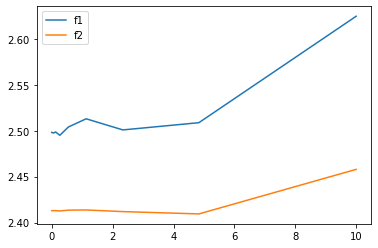

In [449]:
res = np.array(res)
plt.plot(eps_space, res[:, 0], label="f1")
plt.plot(eps_space, res[:, 1], label="f2")
plt.legend()

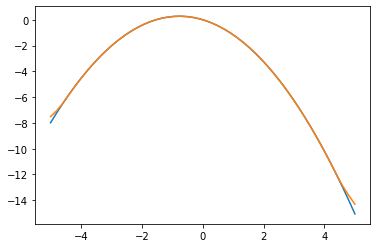

In [378]:
xs = jnp.linspace(-5, 5, 50)

eps = 0

ys = F(S) + np.random.uniform(size=N)* eps

# rbf = RBFInterpolator(S.T , ys)
# rbf_out = rbf(xs.reshape(-1, 1))

rbf = get_rbf(x_0, S.reshape(1, -1), ys)
rbf_out = np.array([rbf(x) for x in xs.reshape(-1, 1)])

plt.plot(xs, F(xs.reshape(1, -1)))
plt.plot(xs, rbf_out)

In [372]:
rbf_out

array([-7.51327922e+00, -7.05031035e+00, -6.47591885e+00, -5.78342299e+00,
       -5.11356480e+00, -4.48765648e+00, -3.90249569e+00, -3.35557030e+00,
       -2.84699991e+00, -2.37683867e+00, -1.94601941e+00, -1.55204251e+00,
       -1.19731190e+00, -8.81275396e-01, -6.02213331e-01, -3.62381190e-01,
       -1.61159244e-01,  1.62220451e-03,  1.26494884e-01,  2.12585516e-01,
        2.60340633e-01,  2.69679636e-01,  2.40441636e-01,  1.73166258e-01,
        6.73348773e-02, -7.71892890e-02, -2.59755340e-01, -4.80709231e-01,
       -7.40115097e-01, -1.03830232e+00, -1.37424929e+00, -1.74895386e+00,
       -2.16196043e+00, -2.61388683e+00, -3.10375481e+00, -3.63174465e+00,
       -4.19913917e+00, -4.80353907e+00, -5.44679532e+00, -6.12890681e+00,
       -6.85012462e+00, -7.60762242e+00, -8.40477563e+00, -9.24026011e+00,
       -1.01158220e+01, -1.10308782e+01, -1.19814129e+01, -1.28735996e+01,
       -1.36216722e+01, -1.43016954e+01])

In [414]:
f1

DeviceArray([[-0.06306624],
             [ 1.68045701],
             [ 7.61965151],
             [-0.13264907],
             [21.59247241],
             [15.26633634],
             [ 3.07693546],
             [-3.8110191 ],
             [-1.90396513],
             [ 1.0192627 ]], dtype=float64)

In [439]:
rbf = RBFInterpolator(S.T, ys) #get_rbf(x_0, S, ys)

In [440]:
rbf(x_0)

array([45.74626397])

In [441]:
h = 1e-5

e = jnp.eye(dim)[0]

x_0 = np.ones(dim).reshape(1, -1)



(rbf(x_0 + e * h) - rbf(x_0))/h

array([-0.34858372])

In [446]:
jnp.linalg.norm(f1.flatten() - get_H_rbf(x_0, S, ys)[1].flatten())

DeviceArray(2.89387263, dtype=float64)

In [436]:
get_H_rbf(x_0, S, ys)[1]

DeviceArray([[-0.34858362,  1.56603207,  9.26814638, -0.20017696,
              21.98013189, 16.48546854,  2.83448474, -4.37968818,
              -3.23538455,  2.34831591]], dtype=float64)

In [437]:
h = 1e-8
(rbf_tmp(x_0.reshape(-1, 1) + h) - rbf_tmp(x_0.reshape(-1, 1)))/h

TypeError: sub got incompatible shapes for broadcasting: (10, 1), (50, 1).